In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-02 12:21:12.110408: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 12:21:12.147503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 12:21:12.147541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 12:21:12.148625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 12:21:12.155065: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

tabledataの作成

In [3]:
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('Data/tabledata_all.csv')
df_neg = df[df['Adducttype'].str.contains('\]\-') | df['Adducttype'].str.contains('\]2\-')]
df_neg2 = model_base.cal_df_sel_column(df_neg)
df_neg_wide = model_base.cal_wide_df(df_neg2)

In [23]:
columnlist_path = 'Data/model_data/neg/negmodelcolumn_all.pkl'
replacement_dict_path = 'Data/model_data/neg/neg_replacement_dict_all.pkl'
y_test_path = 'Data/model_data/neg/df_neg_ytest.csv'

df_neg_wide2, X_train, X_test, X_eval, y_train, y_test, y_eval, train_d, test_d, y, replacement_dict = \
    model_base.train_test_split_from_df(df_neg_wide, columnlist_path, replacement_dict_path, y_test_path) #split data

y_train_onehot, y_test_onehot, y_eval_onehot = model_base.replace_y_onthot(y, y_train, y_test, y_eval, replacement_dict) #onehot

パラメーターチューニング

In [10]:
model, early_stopping, tensorboard_callback =\
      model_base.prep_patam_tune('neg', X_train, y_train_onehot, X_eval, y_eval_onehot)

# モデルの学習
history = model.fit(X_train, y_train_onehot,                  # トレーニングデータ
                    epochs=500,                        # トレーニングの回数
                    batch_size=30,                     # 勾配更新ごとのサンプル数
                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）
                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ
                    callbacks=[early_stopping,tensorboard_callback]) 

model.save('models/neg_class_model')

"\nmodel, early_stopping, tensorboard_callback =      model_base.prep_patam_tune('neg', X_train, y_train_onehot, X_eval, y_eval_onehot)\n\n# モデルの学習\nhistory = model.fit(X_train, y_train_onehot,                  # トレーニングデータ\n                    epochs=500,                        # トレーニングの回数\n                    batch_size=30,                     # 勾配更新ごとのサンプル数\n                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）\n                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ\n                    callbacks=[early_stopping,tensorboard_callback]) \n\nmodel.save('models/neg_class_model')\n"

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2816)              5955840   
                                                                 
 dropout (Dropout)           (None, 2816)              0         
                                                                 
 dense_7 (Dense)             (None, 3968)              11177856  
                                                                 
 dropout_1 (Dropout)         (None, 3968)              0         
                                                                 
 dense_8 (Dense)             (None, 2176)              8636544   
                                                                 
 dropout_2 (Dropout)         (None, 2176)              0         
                                                                 
 dense_9 (Dense)             (None, 69)               

In [50]:
# モデルの定義
model = Sequential()
input_dim = 2114
model.add(Dense(2816, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3968, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2176, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(69, activation='softmax'))

# モデルの描画
plot_model(model, to_file='Data/model_data/neg/neg_model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


SHAP plot

In [42]:
output_path = 'Data/model_data/neg/neg_df_feature.csv'
df_feature = model_base.cal_df_feature(df_neg_wide, output_path)

In [ ]:
neg_class_list = ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE','PC', 'PE', 'PI', 'PS','SM']
X_train_shap, y_train_shap, X_test_shap, y_test_shap =\
    model_base.cal_shap_values(neg_class_list, train_d, test_d)

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train_shap)
shap_values = explainer.shap_values(X_test_shap)
np.save('Data/model_data/neg/neg_shapvalues.npy', shap_values)

input_path = 'Data/model_data/neg/neg_shapvalues.npy'
save_excle_path = 'Data/model_data/neg/shap_select10_neg.xlsx'

top_feature_df =\
      model_base.cal_shap_results(input_path, df_feature, neg_class_list, y_test_shap, save_excle_path)

In [ ]:
cl = plt.cm.tab20.colors
cmap_neg= [cl[0], cl[2], cl[3], cl[4], cl[5], cl[6], cl[7], cl[12], cl[13], cl[8]]
custom_legend_order =   ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE', 'PC', 'PE', 'PI', 'PS', 'SM'] 
save_path = 'Data/model_data/neg/neg_shap.svg'
model_base.plot_shap_results(top_feature_df, cmap_neg, custom_legend_order, save_path, title= 'SHAP summary plot (Negative ion mode model)')

モデルの学習曲線

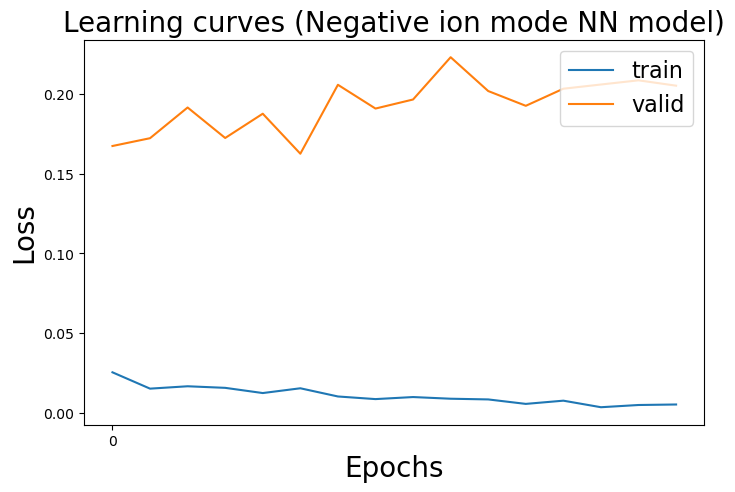

In [62]:
save_path = 'Data/model_data/neg/neg_learning_curve.svg'
model_base.plot_learning_curve(history, save_path, title = 'Learning curves (Negative ion mode NN model)')

Train, testにおける正答率

In [61]:
model = load_model('models/neg_class_model')

In [54]:
y_pred_train, y_pred_train_max, y_train_acc, y_pred_test, y_pred_test_max, y_test_acc =\
    model_base.modelpred_summary_acc(model, X_train, y_train_onehot, X_test, y_test_onehot)

52/52 [==============================] - 0s 5ms/step
Neural Network_train : 0.996937212863706
Neural Network_test : 0.9608083282302511


予測結果のまとめ

In [55]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_train_x = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),pd.DataFrame(y_pred_train).rename(columns=replacement_dict_reversed)], axis=1).groupby('Ontology').mean()
df_train_x = df_train_x.reindex(sorted(df_train_x.columns), axis=1)

In [63]:
print('train result')
train_save_path = 'Data/model_data/neg/neg_df_train_predclass.csv'
train_pred1st_num, train_candidate_num, train_all_num, train_df_predclass =\
    model_base.modelpred_summary_detail(df_neg_wide2, replacement_dict_reversed, y_train, y_pred_train, y_pred_train_max, y_train_acc, train_save_path)
print('test result')
test_save_path = 'Data/model_data/neg/neg_df_test_predclass.csv'
test_pred1st_num, test_candidate_num, test_all_num, test_df_predclass =\
    model_base.modelpred_summary_detail(df_neg_wide2, replacement_dict_reversed, y_test, y_pred_test, y_pred_test_max, y_test_acc, test_save_path)

df_model_result = pd.DataFrame(data=[train_pred1st_num,train_candidate_num, train_all_num, test_pred1st_num, test_candidate_num, test_all_num], \
                               index=['train_1st', 'train_candidate', 'train_number','test_1st', 'test_candidate','test_number'])
df_model_result.to_csv('Data/model_data/neg/df_neg_model_pred_result.csv')

train result
1st pred : 0.996937212863706
candidate : 0.9994257274119449
1st pred num: 5208
candidate num: 5221
all num: 5224
test result
1st pred : 0.9608083282302511
candidate : 0.9846907532149418
1st pred num: 1569
candidate num: 1608
all num: 1633


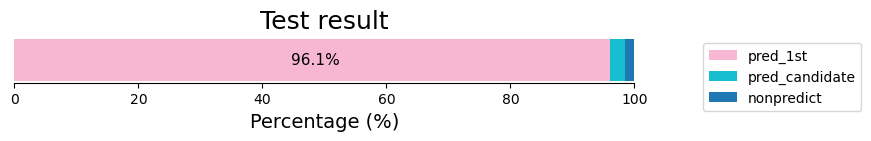

In [58]:
save_path = 'Data/model_data/neg/neg_testresult_percentage.svg'
model_base.plot_bar_plot(test_pred1st_num, test_candidate_num, test_all_num, save_path)

canopusとの比較用データの準備

In [60]:
ont_df_path = 'Data/model_data/neg/subclass_ont_select_neg.csv'
save_path = 'Data/model_data/neg/df_neg_subclass_pred.csv'
subclasslist = ['Glycerophosphoethanolamines', 'Glycerophosphocholines',
 'Ceramides', 'Glycerophosphoinositols', 'Glycerophosphoglycerols',
 'Glycerophosphoserines', 'Phosphosphingolipids', 'Fatty acids and conjugates']
model_base.conv_subclass(test_df_predclass, y_test, ont_df_path, save_path, subclasslist)